In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [2]:
START_DATE = date(2000, 1, 1)
END_DATE = date(2023, 1, 31)

In [3]:
def read_yahoo_csv(filepath):
    df = pd.read_csv(filepath)[["Date", "Adj Close"]]
    df["Date"] = pd.to_datetime(df["Date"])

    column_name = ".".join(os.path.basename(filepath).split(".")[:-1])

    df.rename(columns = {"Adj Close": column_name}, inplace = True)
    return df

def read_yahoo_folder(folderpath, start, end):
    df = pd.DataFrame({'Date': pd.date_range(start, end, freq = 'D')})

    with os.scandir(folderpath) as entries:
        for entry in entries:
            df = df.merge(read_yahoo_csv(entry), on = "Date", how = "left")

    df.set_index("Date", inplace = True)
    return df

Data downloaded manually from the Yahoo Finance website.

In [4]:
etf_df = read_yahoo_folder("data/etfs/", START_DATE, END_DATE)
exchange_rates_df = read_yahoo_folder("data/exchange-rates/", START_DATE, END_DATE)

[Text(0.5, 1.0, 'ETF prices in original currencies'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Price')]

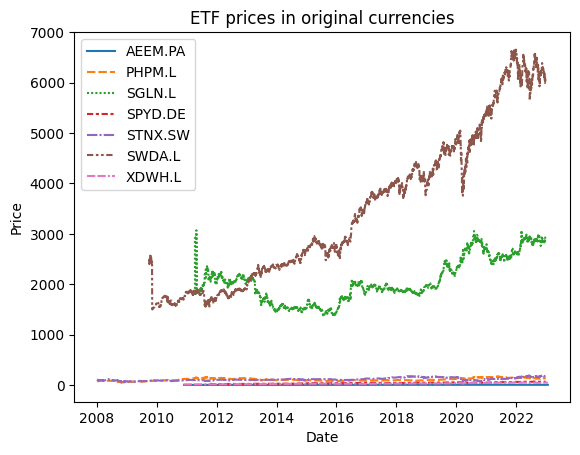

In [5]:
plot = sns.lineplot(data = etf_df)
plot.set(
    title = "ETF prices in original currencies",
    xlabel = "Date",
    ylabel = "Price")

[Text(0.5, 1.0, 'Exchange rates to PLN'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Price of currency in PLN')]

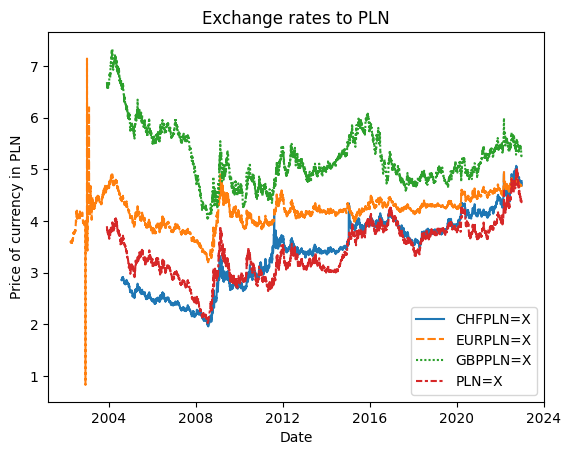

In [6]:
plot = sns.lineplot(data = exchange_rates_df)
plot.set(
    title = "Exchange rates to PLN",
    xlabel = "Date",
    ylabel = "Price of currency in PLN")

There is something weird going on with the EUR to PLN plot around 2002-2003, but let's ignore this for now. This period will fall out of the analysis anyways.

Keep in mind that the weirdly labeled `PLN=X` item stands for the USD to PLN exchange rate. The name comes from the label on the Yahoo Finance website.

This is not very useful just yet. Let's bring all values to PLN first. Note that Yahoo Finance presents some ETF's values in fractions.

In [7]:
etf_currencies = {
    "SGLN.L": ["GBPPLN=X", 0.01],
    "STNX.SW": ["CHFPLN=X", 1],
    "SWDA.L": ["GBPPLN=X", 0.01],
    "PHPM.L": ["PLN=X", 1],
    "SPYD.DE": ["EURPLN=X", 1],
    "AEEM.PA": ["EURPLN=X", 1],
    "XDWH.L": ["PLN=X", 1],
}

for column_name in etf_df.columns:
    etf_df[column_name] = etf_df[column_name] * exchange_rates_df[etf_currencies[column_name][0]] * etf_currencies[column_name][1]

Now, let's remove rows where the data is not full, so that all series start from the same point in time.

In [8]:
etf_df.dropna(inplace = True)

 Also, let's standarise the output, to make it easier to see differences in value. Before we do that, let's write down the latest prices.

In [9]:
latest_prices = get_latest_prices(etf_df)

etf_df = etf_df.div(etf_df.iloc[0] / 100)

In [10]:
latest_prices

AEEM.PA     19.888197
PHPM.L     586.651109
SGLN.L     152.883882
SPYD.DE    302.034633
STNX.SW    854.922003
SWDA.L     319.144446
XDWH.L     213.132837
Name: 2022-12-23 00:00:00, dtype: float64

In [11]:
etf_df

,AEEM.PA,PHPM.L,SGLN.L,SPYD.DE,STNX.SW,SWDA.L,XDWH.L
Date,,,,,,,
2011-10-14,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2011-10-17,101.492397,99.424854,100.311243,99.948786,100.326435,99.247750,97.428794
2011-10-18,101.746175,99.193810,100.218232,101.354843,102.080533,100.849047,100.172831
2011-10-19,101.491453,99.778431,99.487012,100.938815,103.302874,101.127185,100.044201
2011-10-20,99.486979,96.689167,97.927457,100.452838,101.673715,100.003301,99.699632
...,...,...,...,...,...,...,...
2022-12-19,181.435277,144.741134,148.138956,380.341403,264.130341,386.204800,525.286624
2022-12-20,180.767466,147.663010,150.205653,377.569842,263.535363,384.796731,522.567402
2022-12-21,181.354428,146.104063,150.683401,383.493156,268.213853,392.060799,528.011087


[Text(0.5, 1.0, 'Portfolio components history in standardized prices'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Relative value in PLN')]

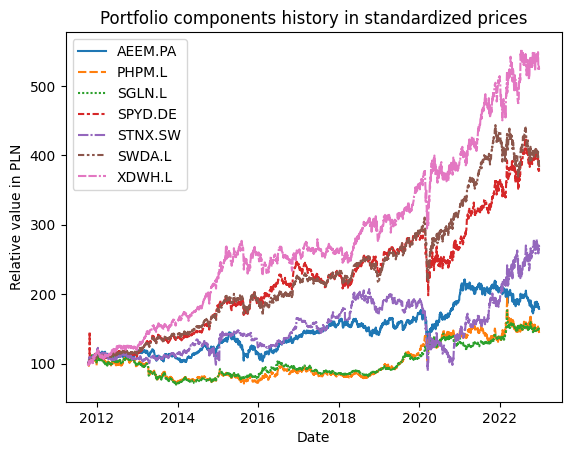

In [12]:
plot = sns.lineplot(data = etf_df)
plot.set(
    title = "Portfolio components history in standardized prices",
    xlabel = "Date",
    ylabel = "Relative value in PLN")

## Evaluation
Now it's time for the portfolio evaluation. First we need to convert the ratings into daily percentage changes.

In [13]:
returns_df = etf_df.pct_change()
returns_df

,AEEM.PA,PHPM.L,SGLN.L,SPYD.DE,STNX.SW,SWDA.L,XDWH.L
Date,,,,,,,
2011-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-17,0.014924,-0.005751,0.003112,-0.000512,0.003264,-0.007523,-0.025712
2011-10-18,0.002500,-0.002324,-0.000927,0.014068,0.017484,0.016134,0.028165
2011-10-19,-0.002504,0.005894,-0.007296,-0.004105,0.011974,0.002758,-0.001284
2011-10-20,-0.019750,-0.030961,-0.015676,-0.004815,-0.015771,-0.011114,-0.003444
...,...,...,...,...,...,...,...
2022-12-19,-0.001785,-0.004889,0.000719,0.000986,0.021518,-0.002203,0.001745
2022-12-20,-0.003681,0.020187,0.013951,-0.007287,-0.002253,-0.003646,-0.005177
2022-12-21,0.003247,-0.010557,0.003181,0.015688,0.017753,0.018878,0.010417


The next step is to create the annualized covariance matrix.

In [14]:
covariance_matrix = risk_models.sample_cov(etf_df)
covariance_matrix

,AEEM.PA,PHPM.L,SGLN.L,SPYD.DE,STNX.SW,SWDA.L,XDWH.L
AEEM.PA,0.036131,0.010480,0.002134,0.021930,0.019958,0.020289,0.016826
PHPM.L,0.010480,0.048846,0.028107,0.008856,0.017545,0.010997,0.017446
SGLN.L,0.002134,0.028107,0.033689,0.001403,0.006274,0.010124,0.005845
SPYD.DE,0.021930,0.008856,0.001403,0.058459,0.022050,0.024385,0.021544
STNX.SW,0.019958,0.017545,0.006274,0.022050,0.071507,0.019126,0.017903
SWDA.L,0.020289,0.010997,0.010124,0.024385,0.019126,0.031257,0.022188
XDWH.L,0.016826,0.017446,0.005845,0.021544,0.017903,0.022188,0.033687


Let's generate a random portfolio (i.e. a vector of non-negative numbers which sum up to one). For the details of how the function works, please see discussion in the [other notebook](random_portfolio_generator.ipynb).

In [15]:
from ipynb.fs.defs.random_portfolio_generator import generate_random_weights

Now we assign weights to the stocks.

In [17]:
weights = generate_random_weights(covariance_matrix.shape[0])

Now we calculate the variance of the specified portfolio.

In [18]:
portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
portfolio_variance

0.023362673145688805

Now we calculate the volatility (standard deviation) of the specified portfolio.

In [19]:
portfolio_volatility = np.sqrt(portfolio_variance)
portfolio_volatility

0.15284853007369356

Now we calculate the expected annual return from the portfolio.

In [20]:
portfolio_simple_annual_return = (np.sum(returns_df.mean() * weights) + 1) ** 252 - 1
portfolio_simple_annual_return

0.14548034329505022

Show the expected annual return and volatility (risk, standard deviation).

In [21]:
print("Expected annual return: {:.2%}".format(portfolio_simple_annual_return))
print("Expected annual volatility: {:.2%}".format(portfolio_volatility))

Expected annual return: 14.55%
Expected annual volatility: 15.28%


## Portfolio optimisation
Calculate the expected returns and the annualised sample covariance matrix of asset returns

In [22]:
mean_historical_returns = expected_returns.mean_historical_return(etf_df)

Optimize for max Sharpe ratio

In [23]:
ef = EfficientFrontier(mean_historical_returns, covariance_matrix)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose = True)

OrderedDict([('AEEM.PA', 0.0), ('PHPM.L', 0.0), ('SGLN.L', 0.0), ('SPYD.DE', 0.04151), ('STNX.SW', 0.0), ('SWDA.L', 0.18095), ('XDWH.L', 0.77754)])
Expected annual return: 15.9%
Annual volatility: 17.2%
Sharpe Ratio: 0.81


(0.1592932537886897, 0.17172824113493937, 0.8111260726139788)

Get the discrete allocation of each share per stock

In [24]:
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value = 50000)

allocation, leftover = da.lp_portfolio()
print("Discrete Allocation:", allocation)
print("Funds Remaining: {:.2f} zł".format(leftover))

Discrete Allocation: {'AEEM.PA': 1, 'SPYD.DE': 7, 'SWDA.L': 28, 'XDWH.L': 182}
Funds Remaining: 139.65 zł


In [40]:
def generate_and_evaluate_random_portfolios(num_portfolios, covariance_matrix):
    
    results = np.zeros((num_portfolios, 2))

    for i in range(num_portfolios):
        weights = generate_random_weights(covariance_matrix.shape[0])
        results[i, 0] = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
        results[i, 1] = (np.sum(returns_df.mean() * weights) + 1) ** 252 - 1

    results = pd.DataFrame(results)
    results.columns = ["Annualised volatility", "Annualised return"]

    return results

In [45]:
portfolio_evaluations = generate_and_evaluate_random_portfolios(100_000, covariance_matrix)

[Text(0.5, 1.0, "Random portfolios' performance")]

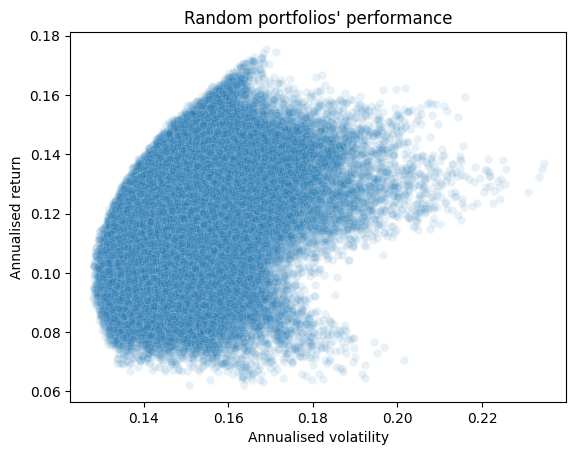

In [53]:
random_portfolios_plot = sns.scatterplot(
    data = pd.DataFrame(portfolio_evaluations),
    alpha = .1,
    x = "Annualised volatility",
    y = "Annualised return")

random_portfolios_plot.set(title = "Random portfolios' performance")